[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/espnet/interspeech2019-tutorial/blob/master/notebooks/interspeech2019_tts/interspeech2019_tts.ipynb)

# [T6] Advanced methods for neural end-to-end speech processing – unification, integration, and implementation -

### Part4 : Building End-to-End TTS System

Speaker: [**Tomoki Hayashi**](https://github.com/kan-bayashi)

Department of informatics, Nagoya University  
Human Dataware Lab. Co., Ltd.


Good afternoon, everyone.  
This is Tomoki Hayashi, doctroral researcher @ Nagoya University.  
From here, I will introduce the demonstration of the development of E2E-TTS system in ESPnet.  
As the same as Dr. Karita's presentation, I will use google colaboratory for this hands-on.  
So please access the tutorial material page and open the TTS hands on in your browser.

## TOC

0. Installation
1. Introduction of ESPnet TTS
2. Demonstration of the ESPnet TTS recipe
3. Demonstration of the use of pretrained models
4. Conclusion & development plan

This is the table of contents of my presentation.

## 0. Installation
 
It takes around 3 minutes. Please keep waiting for a while.


In [ ]:
# OS setup
!cat /etc/os-release
!apt-get install -qq bc tree sox

# espnet setup
!git clone --depth 5 https://github.com/espnet/espnet
!pip install -q torch==1.1
!cd espnet; pip install -q -e .

# download pre-compiled warp-ctc and kaldi tools
!espnet/utils/download_from_google_drive.sh \
    "https://drive.google.com/open?id=13Y4tSygc8WtqzvAVGK_vRV9GlV7TRC0w" espnet/tools tar.gz > /dev/null
!cd espnet/tools/warp-ctc/pytorch_binding && \
    pip install -U dist/warpctc_pytorch-0.1.1-cp36-cp36m-linux_x86_64.whl

# make dummy activate
!mkdir -p espnet/tools/venv/bin && touch espnet/tools/venv/bin/activate
!echo "setup done."

First, installation.  
Please run the cell and keep waiting for a while.  
This installation process is the same as ASR.

## 1. Introduction of ESPnet TTS

- Follow the [Kaldi](https://github.com/kaldi-asr/kaldi) style recipe
- Support three E2E-TTS models and their variants
- Support four corpus including English, Japanese, Italy, Spanish, and Germany
- Support pretrained WaveNet-vocoder (Softmax and MoL version)

Samples are available in https://espnet.github.io/espnet-tts-sample/

During the installation, I will introduce the ESPnet TTS systems.  
TTS recipes also follow the kaldi-style recipe, the most of preprocessing steps are the exactly same as the ASR.  
Currently we support three E2E-TTS models and their variants.  
We support four corpus including English, Japanese, Italy, Spanish and Germany.  
Also, we support pretrained WaveNet vocoder. So you can generate higher quality speech.  

### Supported E2E-TTS models

- [**Tacotron 2**](https://arxiv.org/abs/1712.05884): Standard Tacontron 2
- [**Multi-speaker Tacotron2**](https://arxiv.org/pdf/1806.04558.pdf): Pretrained x-vector + Tacotron 2
- [**Transformer**](https://arxiv.org/pdf/1809.08895.pdf): TTS-Transformer
- [**Multi-speaker Transformer**](): Pretrained x-vector + TTS-Transformer
- [**FastSpeech**](https://arxiv.org/pdf/1905.09263.pdf): Feed-forward TTS-Transformer


We support following E2E-TTS models.
Tacotron2, Multi-speaker Tacotron2 using pretrained X-vector, Transformer, Multi-speaker Transformer with pretrained X-vector, and FastSpeech also known as feed-forward Transformer.

### Other remarkable functions

- [**CBHG**](https://arxiv.org/pdf/1703.10135.pdf): Network to convert Mel-filter bank to linear spectrogram
- [**Forward attention**](https://arxiv.org/pdf/1807.06736.pdf): Attention mechanism with causal regularization
- [**Guided attention loss**](https://arxiv.org/pdf/1710.08969.pdf): Loss function to force attention to be diagonal

As other remarkable functions, we support CBHG network, which convert mel-filter bank to linear spectrogram, and forward attention, which has a causal regularization, and guided attention loss, which force attention to be diagonal.  
During the training, we can combine these function to train E2E-TTS models.

### Supported corpus

- [`egs/jsut/tts1`](https://sites.google.com/site/shinnosuketakamichi/publication/jsut): Japanese single female speaker. (48 kHz, ~10 hours)
- [`egs/libritts/tts1`](http://www.openslr.org/60/): English multi speakers (24 kHz, ~500 hours).
- [`egs/ljspeech/tts1`](https://keithito.com/LJ-Speech-Dataset/): English single female speaker (22.05 kHz, ~24 hours).
- [`egs/m_ailabs/tts1`](https://www.caito.de/2019/01/the-m-ailabs-speech-dataset/): Various language speakers (16 kHz, 16~48 hours).

Here is the list of supported corpus, and recipes.  
JSUT, LibriTTS, LJspeech and M ailabs speech dataset.  
You can build various language TTS model through the ESPnet!

## 2. Demonstration of ESPnet-TTS recipes
 
Here use the recipe `egs/an4/tts1` as an example.  

Unfortunately, `egs/an4/tts1` is too small to train,
but the flow itself is the same as the other recipes.

Maybe you finished the installation, right?  
Let us move on the demonstration of ESPnet TTS recipe.  
Here we use the recipe `egs/an4/tts1`, which is a TTS version of `egs/an4/asr1`.  
Unfortunately, `egs/an4/tts1` is too small to train, but the flow itself is the same as the other recipes.  
So you can understand the basic flow of TTS recipes.

Always we organize each recipe placed in `egs/xxx/tts1` in the same manner:

- `run.sh`: Main script of the recipe.
- `cmd.sh`: Command configuration script to control how-to-run each job.
- `path.sh`: Path configuration script. Basically, we do not need to touch.
- `conf/`: Directory containing configuration files e.g.g.
- `local/`: Directory containing the recipe-specific scripts e.g. data preparation.
- `steps/` and `utils/`: Directory containing kaldi tools.

The scripts are the same as ASR.

We alway organize each recipe placed in `egs/xxx/tts1` in the same manner.  
Let us move on the recipe directory and check the file. please run the following cell.  
Each recipe contains the main script run.sh, command configuration script cmd.sh, path configuration script path.sh.  
Also there are some directories, conf is the directory including configuration files, local is the directory including the recipe-specific scripts such as data preparation, and steps and utils the directories including kaldi tools.  
Maybe you can confirm that the scripts and the structure are the same as ASR recipe.

In [1]:
# move on the recipe directory
import os
os.chdir("espnet/egs/an4/tts1")

# check files
!tree -L 1

.
├── cmd.sh
├── conf
├── local -> ../asr1/local
├── path.sh
├── run.sh
├── steps -> ../../../tools/kaldi/egs/wsj/s5/steps
└── utils -> ../../../tools/kaldi/egs/wsj/s5/utils

4 directories, 3 files


Main script `run.sh` consists of several stages:

<div align=center>
    <img src=figs/tts_brief_overview.png width=75%>
</div>

- **stage -1**: Download data if the data is available online.
- **stage 0**: Prepare data to make kaldi-stype data directory.
- **stage 1**: Extract feature vector, calculate statistics, and normalize.
- **stage 2**: Prepare a dictionary and make json files for training.
- **stage 3**: Train the E2E-TTS network.
- **stage 4**: Decode mel-spectrogram using the trained network.
- **stage 5**: Generate a waveform using Griffin-Lim.

From **stage -1 to 2 are the same as the ASR** recipe.

The main script run.sh consists of several stages from -1 to 5, in total 6 stages.  
Data download, kaldi-style data preparation, feature extraction, data conversion for json format, Training, decoding and synthesis.  
Stage 0 and 1 are performed with kaldi and librosa, and stage 3 and 4 are performed by pytorch.  
Maybe you can understand that from stage -1 to stage 2 are the same as ASR.  
We have the unified flow in both TTS and ASR.

### Detail overview
<div align=center>
    <img src=figs/tts_overview.png width=90%>
</div>

This figure shows the detail flow of each recipe.  
I will introduce each stage step-by-step.

### Stage -1: Data download

This stage downloads corpus if it is available online.

<div align=center>
    <img src=figs/tts_stage-1.png width=80%>
</div>

First, stage -1 data download.  
This stage downloads corpus from cloud if the data is available online.

In [2]:
# run stage -1 and then stop
!./run.sh --stage -1 --stop_stage -1

stage -1: Data Download
local/download_and_untar.sh: downloading data (64 MB) from http://www.speech.cs.cmu.edu/databases/an4//an4_sphere.tar.gz.
--2019-09-12 17:03:00--  http://www.speech.cs.cmu.edu/databases/an4//an4_sphere.tar.gz
Resolving www.speech.cs.cmu.edu (www.speech.cs.cmu.edu)... 128.2.204.214
Connecting to www.speech.cs.cmu.edu (www.speech.cs.cmu.edu)|128.2.204.214|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64327561 (61M) [application/x-gzip]
Saving to: 'an4_sphere.tar.gz'

an4_sphere.tar.gz   100%[===================>]  61.35M  6.13MB/s    in 22s     

2019-09-12 17:03:24 (2.76 MB/s) - 'an4_sphere.tar.gz' saved [64327561/64327561]

local/download_and_untar.sh: line 57: cd: ./downloads: No such file or directory
an4/
an4/README
an4/etc/
an4/etc/an4_test.fileids
an4/etc/an4.ug.lm
an4/etc/an4.ug.lm.DMP
an4/etc/an4_train.fileids
an4/etc/an4_train.transcription
an4/etc/an4_test.transcription
an4/etc/an4.dic
an4/etc/an4.phone
an4/etc/an4.filler
an4/

an4/wav/an4_clstk/fplp/an92-fplp-b.sph
an4/wav/an4_clstk/fplp/an93-fplp-b.sph
an4/wav/an4_clstk/fplp/an94-fplp-b.sph
an4/wav/an4_clstk/fplp/an95-fplp-b.sph
an4/wav/an4_clstk/fplp/cen1-fplp-b.sph
an4/wav/an4_clstk/fplp/cen2-fplp-b.sph
an4/wav/an4_clstk/fplp/cen3-fplp-b.sph
an4/wav/an4_clstk/fplp/cen4-fplp-b.sph
an4/wav/an4_clstk/fplp/cen5-fplp-b.sph
an4/wav/an4_clstk/fplp/cen6-fplp-b.sph
an4/wav/an4_clstk/fplp/cen7-fplp-b.sph
an4/wav/an4_clstk/fplp/cen8-fplp-b.sph
an4/wav/an4_clstk/fsaf2/
an4/wav/an4_clstk/fsaf2/an296-fsaf2-b.sph
an4/wav/an4_clstk/fsaf2/an297-fsaf2-b.sph
an4/wav/an4_clstk/fsaf2/an298-fsaf2-b.sph
an4/wav/an4_clstk/fsaf2/an299-fsaf2-b.sph
an4/wav/an4_clstk/fsaf2/an300-fsaf2-b.sph
an4/wav/an4_clstk/fsaf2/cen1-fsaf2-b.sph
an4/wav/an4_clstk/fsaf2/cen2-fsaf2-b.sph
an4/wav/an4_clstk/fsaf2/cen3-fsaf2-b.sph
an4/wav/an4_clstk/fsaf2/cen4-fsaf2-b.sph
an4/wav/an4_clstk/fsaf2/cen5-fsaf2-b.sph
an4/wav/an4_clstk/fsaf2/cen6-fsaf2-b.sph
an4/wav/an4_clstk/fsaf2/cen7-fsaf2-b.sph
an4/wav/an

an4/wav/an4_clstk/mdmc/cen7-mdmc-b.sph
an4/wav/an4_clstk/mdmc/cen8-mdmc-b.sph
an4/wav/an4_clstk/mdxn/
an4/wav/an4_clstk/mdxn/an106-mdxn-b.sph
an4/wav/an4_clstk/mdxn/an107-mdxn-b.sph
an4/wav/an4_clstk/mdxn/an108-mdxn-b.sph
an4/wav/an4_clstk/mdxn/an109-mdxn-b.sph
an4/wav/an4_clstk/mdxn/an110-mdxn-b.sph
an4/wav/an4_clstk/mdxn/cen1-mdxn-b.sph
an4/wav/an4_clstk/mdxn/cen2-mdxn-b.sph
an4/wav/an4_clstk/mdxn/cen3-mdxn-b.sph
an4/wav/an4_clstk/mdxn/cen4-mdxn-b.sph
an4/wav/an4_clstk/mdxn/cen5-mdxn-b.sph
an4/wav/an4_clstk/mdxn/cen6-mdxn-b.sph
an4/wav/an4_clstk/mdxn/cen7-mdxn-b.sph
an4/wav/an4_clstk/mdxn/cen8-mdxn-b.sph
an4/wav/an4_clstk/mdxs/
an4/wav/an4_clstk/mdxs/an26-mdxs-b.sph
an4/wav/an4_clstk/mdxs/an27-mdxs-b.sph
an4/wav/an4_clstk/mdxs/an28-mdxs-b.sph
an4/wav/an4_clstk/mdxs/an29-mdxs-b.sph
an4/wav/an4_clstk/mdxs/an30-mdxs-b.sph
an4/wav/an4_clstk/mdxs/cen1-mdxs-b.sph
an4/wav/an4_clstk/mdxs/cen2-mdxs-b.sph
an4/wav/an4_clstk/mdxs/cen3-mdxs-b.sph
an4/wav/an4_clstk/mdxs/cen4-mdxs-b.sph
an4/wav/an4

an4/wav/an4_clstk/mmaf/cen6-mmaf-b.sph
an4/wav/an4_clstk/mmaf/cen7-mmaf-b.sph
an4/wav/an4_clstk/mmaf/cen8-mmaf-b.sph
an4/wav/an4_clstk/mmal/
an4/wav/an4_clstk/mmal/an321-mmal-b.sph
an4/wav/an4_clstk/mmal/an322-mmal-b.sph
an4/wav/an4_clstk/mmal/an323-mmal-b.sph
an4/wav/an4_clstk/mmal/an324-mmal-b.sph
an4/wav/an4_clstk/mmal/an325-mmal-b.sph
an4/wav/an4_clstk/mmal/cen1-mmal-b.sph
an4/wav/an4_clstk/mmal/cen2-mmal-b.sph
an4/wav/an4_clstk/mmal/cen3-mmal-b.sph
an4/wav/an4_clstk/mmal/cen4-mmal-b.sph
an4/wav/an4_clstk/mmal/cen5-mmal-b.sph
an4/wav/an4_clstk/mmal/cen6-mmal-b.sph
an4/wav/an4_clstk/mmal/cen7-mmal-b.sph
an4/wav/an4_clstk/mmal/cen8-mmal-b.sph
an4/wav/an4_clstk/mmap/
an4/wav/an4_clstk/mmap/an46-mmap-b.sph
an4/wav/an4_clstk/mmap/an47-mmap-b.sph
an4/wav/an4_clstk/mmap/an48-mmap-b.sph
an4/wav/an4_clstk/mmap/an49-mmap-b.sph
an4/wav/an4_clstk/mmap/an50-mmap-b.sph
an4/wav/an4_clstk/mmap/cen1-mmap-b.sph
an4/wav/an4_clstk/mmap/cen2-mmap-b.sph
an4/wav/an4_clstk/mmap/cen3-mmap-b.sph
an4/wav/an4

an4/wav/an4_clstk/mskh/an97-mskh-b.sph
an4/wav/an4_clstk/mskh/an98-mskh-b.sph
an4/wav/an4_clstk/mskh/an99-mskh-b.sph
an4/wav/an4_clstk/mskh/cen1-mskh-b.sph
an4/wav/an4_clstk/mskh/cen2-mskh-b.sph
an4/wav/an4_clstk/mskh/cen3-mskh-b.sph
an4/wav/an4_clstk/mskh/cen4-mskh-b.sph
an4/wav/an4_clstk/mskh/cen5-mskh-b.sph
an4/wav/an4_clstk/mskh/cen6-mskh-b.sph
an4/wav/an4_clstk/mskh/cen7-mskh-b.sph
an4/wav/an4_clstk/mskh/cen8-mskh-b.sph
an4/wav/an4_clstk/msmn/
an4/wav/an4_clstk/msmn/an276-msmn-b.sph
an4/wav/an4_clstk/msmn/an277-msmn-b.sph
an4/wav/an4_clstk/msmn/an278-msmn-b.sph
an4/wav/an4_clstk/msmn/an279-msmn-b.sph
an4/wav/an4_clstk/msmn/cen4-msmn-b.sph
an4/wav/an4_clstk/msmn/cen5-msmn-b.sph
an4/wav/an4_clstk/msmn/cen6-msmn-b.sph
an4/wav/an4_clstk/msmn/cen7-msmn-b.sph
an4/wav/an4_clstk/msmn/cen8-msmn-b.sph
an4/wav/an4_clstk/msrb/
an4/wav/an4_clstk/msrb/an331-msrb-b.sph
an4/wav/an4_clstk/msrb/an332-msrb-b.sph
an4/wav/an4_clstk/msrb/an333-msrb-b.sph
an4/wav/an4_clstk/msrb/an334-msrb-b.sph
an4/wav/

an4/wav/an4test_clstk/mmxg/an443-mmxg-b.sph
an4/wav/an4test_clstk/mmxg/an444-mmxg-b.sph
an4/wav/an4test_clstk/mmxg/an445-mmxg-b.sph
an4/wav/an4test_clstk/mmxg/cen1-mmxg-b.sph
an4/wav/an4test_clstk/mmxg/cen2-mmxg-b.sph
an4/wav/an4test_clstk/mmxg/cen3-mmxg-b.sph
an4/wav/an4test_clstk/mmxg/cen4-mmxg-b.sph
an4/wav/an4test_clstk/mmxg/cen5-mmxg-b.sph
an4/wav/an4test_clstk/mmxg/cen6-mmxg-b.sph
an4/wav/an4test_clstk/mmxg/cen7-mmxg-b.sph
an4/wav/an4test_clstk/mmxg/cen8-mmxg-b.sph
an4/LICENSE
local/download_and_untar.sh: Successfully downloaded and un-tarred ./downloads/an4_sphere.tar.gz
dictionary: data/lang_1char/train_nodev_units.txt


Please run the cell. And keep waiting for a while.

`downloads` directory is created, which containing downloaded an4 dataset.

In [3]:
!tree -L 2 downloads

downloads
├── an4
│   ├── etc
│   ├── LICENSE
│   ├── README
│   └── wav
└── an4_sphere.tar.gz

3 directories, 3 files


Downloaded files are save in `downloads` directory.  
Let me check the files.  
You can see the corpus is stored in the directory.

### Stage 0: Data preparation

This stage prepares kaldi-style data directories.

<div align=center>
    <img src=figs/tts_stage0.png width=80%>
</div>

Next, stage 0 data preparation.  
This stage prepares the kaldi-style data directories.

In [4]:
# run stage 0 and then stop
!./run.sh --stage 0 --stop_stage 0

stage 0: Data preparation
dictionary: data/lang_1char/train_nodev_units.txt


Please run the cell.

Two kaldi-style data directories are created:  
- `data/train`: data directory of training set
- `data/test`: data directory of evaluation set  

In [5]:
!tree -L 2 data

data
├── test
│   ├── spk2utt
│   ├── text
│   ├── utt2spk
│   └── wav.scp
└── train
    ├── spk2utt
    ├── text
    ├── utt2spk
    └── wav.scp

2 directories, 8 files


Through this stage, 2 kaldi-style data directories are created under the `data` directory.  
Let me check the files.

`wav.scp`: 
- Each line has `<utt_id> <wavfile_path or command pipe>`
- `<utt_id>` must be unique

`text`:
- Each line has `<utt_id> <transcription>`
- Assume that `<transcription>` is cleaned

`utt2spk`:
- Each line has `<utt_id> <speaker_id>`

`spk2utt`:
- Each lien has `<speaker_id> <utt_id> ... <utt_id> `
- Can be automatically created from `utt2spk` 

In the ESPnet, speaker information is **not used for any processing.**   
Therefore, **`utt2spk` and `spk2utt` can be a dummy.**

In [6]:
!head -n 3 data/train/*

==> data/train/spk2utt <==
fash fash-an251-b fash-an253-b fash-an254-b fash-an255-b fash-cen1-b fash-cen2-b fash-cen4-b fash-cen5-b fash-cen7-b
fbbh fbbh-an86-b fbbh-an87-b fbbh-an88-b fbbh-an89-b fbbh-an90-b fbbh-cen1-b fbbh-cen2-b fbbh-cen3-b fbbh-cen4-b fbbh-cen5-b fbbh-cen6-b fbbh-cen7-b fbbh-cen8-b
fclc fclc-an146-b fclc-an147-b fclc-an148-b fclc-an149-b fclc-an150-b fclc-cen1-b fclc-cen2-b fclc-cen3-b fclc-cen4-b fclc-cen5-b fclc-cen6-b fclc-cen7-b fclc-cen8-b

==> data/train/text <==
fash-an251-b YES
fash-an253-b GO
fash-an254-b YES

==> data/train/utt2spk <==
fash-an251-b fash
fash-an253-b fash
fash-an254-b fash

==> data/train/wav.scp <==
fash-an251-b /work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/an4/tts1/../../../tools/kaldi/tools/sph2pipe_v2.5/sph2pipe -f wav -p -c 1 ./downloads/an4/wav/an4_clstk/fash/an251-fash-b.sph |
fash-an253-b /work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/an4/tts1/../../../tool

Maybe most of you are the specialist of the kaldi, you know what these files are.  
So here briefly check the files. please run the cell.
These fundamental files are the same as kaldi but there is an important point.  
That is, in the ESPnet, any speaker information is not used for any processing.  
Therefore utt2spk and spk2utt can be a dummy.  

### Stage 1: Feature extration

This stage performs feature extraction, statistics calculation and normalization.

<div align=center>
    <img src=figs/tts_stage1.png width=80%>
</div>

Next, stage 1 feature extration.  
This stage performes feature extraction, calculatin of statistics of feature vector, and feature normalization using the claculated statistics.

In [7]:
# hyperparameters related to stage 1
!head -n 28 run.sh | tail -n 8

# feature extraction related
fs=16000    # sampling frequency
fmax=""     # maximum frequency
fmin=""     # minimum frequency
n_mels=80   # number of mel basis
n_fft=1024  # number of fft points
n_shift=256 # number of shift points
win_length="" # window length


Let me check the hyperparameters related to stage 1.  
In the TTS, we use mel-filterbank as speech features and they are extracted by librosa.

In [8]:
# run stage 1 with default settings
!./run.sh --stage 1 --stop_stage 1 --nj 4

stage 1: Feature Generation
/work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/an4/tts1/../../../utils/make_fbank.sh --cmd stdout.pl --nj 4 --fs 16000 --fmax  --fmin  --n_fft 1024 --n_shift 256 --win_length  --n_mels 80 data/train exp/make_fbank/train fbank
utils/validate_data_dir.sh: Successfully validated data-directory data/train
/work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/an4/tts1/../../../utils/make_fbank.sh: [info]: no segments file exists: assuming pcm.scp indexed by utterance.
Succeeded creating filterbank features for train
/work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/an4/tts1/../../../utils/make_fbank.sh --cmd stdout.pl --nj 4 --fs 16000 --fmax  --fmin  --n_fft 1024 --n_shift 256 --win_length  --n_mels 80 data/test exp/make_fbank/test fbank
utils/validate_data_dir.sh: Successfully validated data-directory data/test
/work5/t_hayashi/work/is18_tutorial_espnet/notebook

Please run the stage 1.

Raw filterbanks are saved in `fbank/` directory with `ark/scp` format. 

- `.ark`: binary file of feature vector
- `.scp`: list of the correspondance b/w `<utt_id>` and `<path_in_ark>`.  

Since feature extraction can be performed for split small sets in parallel, raw_fbank is split into `raw_fbank_*.{1..4}.{scp,ark}`.

In [9]:
!tree -L 2 fbank

fbank
├── raw_fbank_test.1.ark
├── raw_fbank_test.1.scp
├── raw_fbank_test.2.ark
├── raw_fbank_test.2.scp
├── raw_fbank_test.3.ark
├── raw_fbank_test.3.scp
├── raw_fbank_test.4.ark
├── raw_fbank_test.4.scp
├── raw_fbank_train.1.ark
├── raw_fbank_train.1.scp
├── raw_fbank_train.2.ark
├── raw_fbank_train.2.scp
├── raw_fbank_train.3.ark
├── raw_fbank_train.3.scp
├── raw_fbank_train.4.ark
└── raw_fbank_train.4.scp

0 directories, 16 files


In [10]:
!head -n 3 fbank/raw_fbank_train.1.scp

fash-an251-b /work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/an4/tts1/fbank/raw_fbank_train.1.ark:13
fash-an253-b /work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/an4/tts1/fbank/raw_fbank_train.1.ark:5727
fash-an254-b /work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/an4/tts1/fbank/raw_fbank_train.1.ark:9921


Through the stage 1, extracted raw filterbanks are saved in `fbank` directory with ark/scp format.  
Let me check the files.
.ark is binary file containing the feature vector and .scp is the list of the correspondance between utt_id and path_in_ark.  
Since the feature extraction is performed in parallel, ark/scp files are split into several pieces.

These files can be loaded in python via a great tool **kaldiio** as follows:

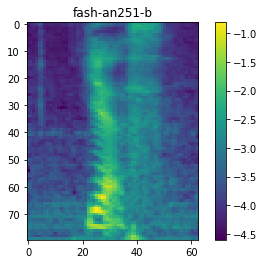

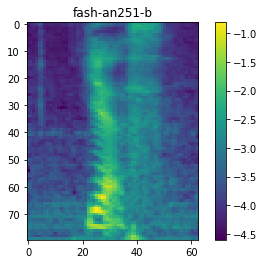

In [11]:
import kaldiio
import matplotlib.pyplot as plt

# load scp file
scp_dict = kaldiio.load_scp("fbank/raw_fbank_train.1.scp")
for key in scp_dict:
    plt.imshow(scp_dict[key].T[::-1])
    plt.title(key)
    plt.colorbar()
    plt.show()
    break
    
# load ark file
ark_generator = kaldiio.load_ark("fbank/raw_fbank_train.1.ark")
for key, array in ark_generator:
    plt.imshow(array.T[::-1])
    plt.title(key)
    plt.colorbar()
    plt.show()
    break

These ark/scp format files can be loaded as numpy.array, thanks to the great tool Kaldiio created by Mr. Kamo.  
Please run the cell.  scp can be loaded as dict and ark can be loaded as a generator.

Some files are added in `data/train`:
- `feats.scp`: concatenated scp file of `fbank/raw_fbank_train.{1..4}.scp`.  
- `utt2num_frames`: Each line has `<utt_id> <number_of_frames>` .

In [12]:
!tree data/train

data/train
├── feats.scp
├── filetype
├── spk2utt
├── text
├── utt2num_frames
├── utt2spk
└── wav.scp

0 directories, 7 files


In [13]:
!head -n 3 data/train/*

==> data/train/feats.scp <==
fash-an251-b /work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/an4/tts1/fbank/raw_fbank_train.1.ark:13
fash-an253-b /work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/an4/tts1/fbank/raw_fbank_train.1.ark:5727
fash-an254-b /work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/an4/tts1/fbank/raw_fbank_train.1.ark:9921

==> data/train/filetype <==
mat

==> data/train/spk2utt <==
fash fash-an251-b fash-an253-b fash-an254-b fash-an255-b fash-cen1-b fash-cen2-b fash-cen4-b fash-cen5-b fash-cen7-b
fbbh fbbh-an86-b fbbh-an87-b fbbh-an88-b fbbh-an89-b fbbh-an90-b fbbh-cen1-b fbbh-cen2-b fbbh-cen3-b fbbh-cen4-b fbbh-cen5-b fbbh-cen6-b fbbh-cen7-b fbbh-cen8-b
fclc fclc-an146-b fclc-an147-b fclc-an148-b fclc-an149-b fclc-an150-b fclc-cen1-b fclc-cen2-b fclc-cen3-b fclc-cen4-b fclc-cen5-b fclc-cen6-b fclc-cen7-b fclc-cen8-b

==> data/train/text <==
fash-an251-b YES
fash-an25

Through feature extraction, some files are added in `data` directories.  
Let me check these files.  
feats.scp is the concatenated scp file of scp files in fbank directory.  
utt2num_frames has the information of number of frames of each utterance.

`data/train/` directory is split into two directories:
- `data/train_nodev/`: data directory for training
- `data/train_dev/`: data directory for validation


In [14]:
!tree data/train_*

data/train_dev
├── feats.scp
├── spk2utt
├── text
├── utt2num_frames
├── utt2spk
└── wav.scp
data/train_nodev
├── cmvn.ark
├── feats.scp
├── spk2utt
├── text
├── utt2num_frames
├── utt2spk
└── wav.scp

0 directories, 13 files


And then data/train directory is split into two directories.  
data/train_nodev and data/train_dev. These are for training and validation respectively.  
Let me check the files. You can see both directories has the same files.

<div align=center>
    <img src=figs/tts_stage1.png width=80%>
</div>

So far, I explained this part.  
Next is statistics calculatin and normalization.

`cmvn.ark` is saved in `data/train_nodev`, which is the statistics file.  
(cepstral mean variance normalization: `cmvn`)  
This file also can be loaded in python via kaldiio.

In [15]:
!tree data/train_nodev

data/train_nodev
├── cmvn.ark
├── feats.scp
├── spk2utt
├── text
├── utt2num_frames
├── utt2spk
└── wav.scp

0 directories, 7 files


statistics file is saved as `cmvn.ark` in data/train_nodev directory.  
Let me check the file.  
This file can also be loaded as numpy.array via kaldiio.

Normalized features for train, dev, and eval sets are dumped in
- `dump/{train_nodev,train_dev,test}/*.{ark,scp}`.  

These ark and scp can be loaded as the same as the above procedure.

In [16]:
!tree dump/*

dump/test
├── feats.1.ark
├── feats.1.scp
├── feats.2.ark
├── feats.2.scp
├── feats.3.ark
├── feats.3.scp
├── feats.4.ark
├── feats.4.scp
├── feats.scp
├── filetype
└── utt2num_frames
dump/train_dev
├── feats.1.ark
├── feats.1.scp
├── feats.2.ark
├── feats.2.scp
├── feats.3.ark
├── feats.3.scp
├── feats.4.ark
├── feats.4.scp
├── feats.scp
├── filetype
└── utt2num_frames
dump/train_nodev
├── feats.1.ark
├── feats.1.scp
├── feats.2.ark
├── feats.2.scp
├── feats.3.ark
├── feats.3.scp
├── feats.4.ark
├── feats.4.scp
├── feats.scp
├── filetype
└── utt2num_frames

0 directories, 33 files


And finally, normalized features for training, validation, and evaluation set are saved in `dump` directory with the ark/scp format.
Let me check the files.  
We also support online normalization during training, but basically to reduce the cpu calculation, we normalize features and then dump them like this.

### Stage 2: Dictionary and json preparation

This stage creates char dict and integrate files into a single json file.

<div align=center>
    <img src=figs/tts_stage2.png width=80%>
</div>

Next stage 2 dictionary and json data preparation.  
This stage creates char dict and integrate kaldi-style directories into a single json file.

In [17]:
# run stage 2 and then stop
!./run.sh --stage 2 --stop_stage 2

dictionary: data/lang_1char/train_nodev_units.txt
stage 2: Dictionary and Json Data Preparation
28 data/lang_1char/train_nodev_units.txt
/work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/an4/tts1/../../../utils/data2json.sh --feat dump/train_nodev/feats.scp data/train_nodev data/lang_1char/train_nodev_units.txt
/work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/an4/tts1/../../../utils/feat_to_shape.sh --cmd run.pl --nj 1 --filetype  --preprocess-conf  --verbose 0 dump/train_nodev/feats.scp data/train_nodev/tmp-Xa4ZI/input/shape.scp
/work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/an4/tts1/../../../utils/data2json.sh --feat dump/train_dev/feats.scp data/train_dev data/lang_1char/train_nodev_units.txt
/work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/an4/tts1/../../../utils/feat_to_shape.sh --cmd run.pl --nj 1 --filetype  --preprocess-conf  --verbose 0 d

Please run the stage 2. 

- Dictionary file is created in `data/lang_1char/`.  
- Dictionary file consists of `<token>` `<token index>`.  
    - `<token index>` starts from 1 because 0 is used as padding index.


In [18]:
!tree data/lang_1char

data/lang_1char
└── train_nodev_units.txt

0 directories, 1 file


In [19]:
!cat data/lang_1char/train_nodev_units.txt

<unk> 1
<space> 2
A 3
B 4
C 5
D 6
E 7
F 8
G 9
H 10
I 11
J 12
K 13
L 14
M 15
N 16
O 17
P 18
Q 19
R 20
S 21
T 22
U 23
V 24
W 25
X 26
Y 27
Z 28


Through this stage, dictionary file is created in data/lang_1char/.  
Let me check the file.  
The dictionary file consists of token and token index.  
The index starts from 1 because 0 is used as padding index in TTS.

Three json files are created for train, dev, and eval sets as 
- `dump/{train_nodev,train_dev,test}/data.json`.

In [20]:
!tree dump -L 2

dump
├── test
│   ├── data.json
│   ├── feats.1.ark
│   ├── feats.1.scp
│   ├── feats.2.ark
│   ├── feats.2.scp
│   ├── feats.3.ark
│   ├── feats.3.scp
│   ├── feats.4.ark
│   ├── feats.4.scp
│   ├── feats.scp
│   ├── filetype
│   ├── log
│   └── utt2num_frames
├── train_dev
│   ├── data.json
│   ├── feats.1.ark
│   ├── feats.1.scp
│   ├── feats.2.ark
│   ├── feats.2.scp
│   ├── feats.3.ark
│   ├── feats.3.scp
│   ├── feats.4.ark
│   ├── feats.4.scp
│   ├── feats.scp
│   ├── filetype
│   ├── log
│   └── utt2num_frames
└── train_nodev
    ├── data.json
    ├── feats.1.ark
    ├── feats.1.scp
    ├── feats.2.ark
    ├── feats.2.scp
    ├── feats.3.ark
    ├── feats.3.scp
    ├── feats.4.ark
    ├── feats.4.scp
    ├── feats.scp
    ├── filetype
    ├── log
    └── utt2num_frames

6 directories, 36 files


And json file for training, validation, and evaluaton set are created under the `dump` directory.  
Let me check the files. You can see the `data.json` in each directory.

Each json file contains all of the information in the data directory.

- `shape`: Shape of the input or output sequence.
- `text`: Original transcription.
- `token`: Token sequence of the transcription.
- `tokenid` Token id sequence converted with `dict` of the transcription

In [21]:
!head -n 27 dump/train_nodev/data.json

{
    "utts": {
        "fash-an251-b": {
            "input": [
                {
                    "feat": "/work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/an4/tts1/dump/train_nodev/feats.1.ark:13",
                    "name": "input1",
                    "shape": [
                        63,
                        80
                    ]
                }
            ],
            "output": [
                {
                    "name": "target1",
                    "shape": [
                        3,
                        30
                    ],
                    "text": "YES",
                    "token": "Y E S",
                    "tokenid": "27 7 21"
                }
            ],
            "utt2spk": "fash"
        },


Let me check the content of json file. Please run the cell.  
Each json contains allfo the information in the kaldi-style data directory.  
for example, shape, text, token, tokenid, spk and so on.  
Some of you noticed that input and output is reversed in terms of TTS.   
This is because we use totally the same json file for TTS as ASR.  

I'm sorry I kept you waiting, now ready to start training!

Now ready to start training!

### Stage 3: Network training

This stage trains E2E-TTS network.

<div align=center>
    <img src=figs/tts_stage3.png width=80%>
</div>

Next, Stage 3 E2E-TTS training.  
This stage trains E2E-TTS network using prepared json files.

Training setting can be specified by `train_config`.

In [22]:
# check hyperparmeters in run.sh
!head -n 31 run.sh | tail -n 2

# config files
train_config=conf/train_pytorch_tacotron2.yaml


Training configuration is written in `.yaml` format file.  
Let us check the default configuration `conf/train_pytroch_tacotron2.yaml`.

The network configuration can be specified by `--train_config` option.  
And the configuration file is written in yaml format.  
Let me check the default configuration conf/train_pytorch_tacotron2.yaml.

In [23]:
!cat conf/train_pytorch_tacotron2.yaml

# This is the basic tactron2 training settting

# encoder related
embed-dim: 512
elayers: 1
eunits: 512
econv-layers: 3 # if set 0, no conv layer is used
econv-chans: 512
econv-filts: 5

# decoder related
dlayers: 2
dunits: 1024
prenet-layers: 2  # if set 0, no prenet is used
prenet-units: 256
postnet-layers: 5 # if set 0, no postnet is used
postnet-chans: 512
postnet-filts: 5

# attention related
atype: location
adim: 128
aconv-chans: 32
aconv-filts: 15      # resulting in filter-size = aconv-filts * 2 + 1
cumulate-att-w: true # whether to cumulate attetion weight
use-batch-norm: true # whether to use batch normalization in conv layer
use-concate: true    # whether to concatenate encoder embedding with decoder lstm outputs
use-residual: false  # whether to use residual connection in encoder convolution
use-masking: true    # whether to mask the padded part in loss calculation
bce-pos-weight: 1.0  # weight for positive samples of stop token in cross-entropy calculation
reduction-factor

There are several hyperparameters.  
The default values are based on the official paper.  
But these values are a little bit big for demonstration.  
So let us change the hyperparameters by editing yaml file.

Let's change the hyperparameters.

In [24]:
# load configuration yaml
import yaml
with open("conf/train_pytorch_tacotron2.yaml") as f:
    params = yaml.load(f, Loader=yaml.Loader)

# change hyperparameters by yourself!
params.update({
    "embed-dim": 16,
    "elayers": 1,
    "eunits": 16,
    "econv-layers": 1,
    "econv-chans": 16,
    "econv-filts": 5,
    "dlayers": 1,
    "dunits": 16,
    "prenet-layers": 1,
    "prenet-units": 16,
    "postnet-layers": 1,
    "postnet-chans": 16,
    "postnet-filts": 5,
    "adim": 16,
    "aconv-chans": 16,
    "aconv-filts": 5,
    "reduction-factor": 5,
    "batch-size": 128,
    "epochs": 5,
    "report-interval-iters": 10,
})

# save
with open("conf/train_pytorch_tacotron2_mini.yaml", "w") as f:
    yaml.dump(params, f, Dumper=yaml.Dumper)

# check modified version
!cat conf/train_pytorch_tacotron2_mini.yaml

aconv-chans: 16
aconv-filts: 5
adim: 16
atype: location
batch-size: 128
batch-sort-key: shuffle
bce-pos-weight: 1.0
cumulate-att-w: true
dlayers: 1
dropout-rate: 0.5
dunits: 16
econv-chans: 16
econv-filts: 5
econv-layers: 1
elayers: 1
embed-dim: 16
epochs: 5
eps: 1e-6
eunits: 16
lr: 1e-3
maxlen-in: 150
maxlen-out: 400
patience: 5
postnet-chans: 16
postnet-filts: 5
postnet-layers: 1
prenet-layers: 1
prenet-units: 16
reduction-factor: 5
report-interval-iters: 10
use-batch-norm: true
use-concate: true
use-masking: true
use-residual: false
weight-decay: 0.0
zoneout-rate: 0.1


Here we show the how to edit in python but of course you can edit it by your favorite editor such as vim.  
We save modified yaml file as train_pytorch_tacotron2_mini.yaml.

Also, we provide `transformer` and `fastspeech` configs.  
Let us check them.

In [25]:
!cat ../../ljspeech/tts1/conf/tuning/train_pytorch_transformer.v1.yaml

# This configuration reuqires 3 gpus in the case of each gpu memory = 12GB, and it takes 3~4 days.
# If you cannot use 3 gpus, it is better to make batch-bins small, increase accum_grad and epochs.
# This model should be able to genearate speeech from around 40k iterations.

# network architecture related
model-module: espnet.nets.pytorch_backend.e2e_tts_transformer:Transformer
embed-dim: 0
eprenet-conv-layers: 0  # one more linear layer w/o non-linear will be added for 0-centor
eprenet-conv-filts: 0
eprenet-conv-chans: 0
dprenet-layers: 2  # one more linear layer w/o non-linear will be added for 0-centor
dprenet-units: 256
adim: 384
aheads: 4
elayers: 6
eunits: 1536
dlayers: 6
dunits: 1536
postnet-layers: 5
postnet-filts: 5
postnet-chans: 256
use-masking: True
bce-pos-weight: 5.0
use-batch-norm: True
use-scaled-pos-enc: True
encoder-normalize-before: False
decoder-normalize-before: False
encoder-concat-after: False
decoder-concat-after: False
reduction-factor: 1

# minibatch related
b

In [26]:
!cat ../../ljspeech/tts1/conf/tuning/train_fastspeech.v2.yaml

# This configuration reuqires 3 gpus in the case of each gpu memory = 12GB.
# To use this configuration, you need the model trained with `conf/tuning/train_transformer.v1`.
# First, you should train the above model or download from google drive and put it in exp dirctory.
# Make sure the `teacher-model` path is valid and the encoder structure is the same as teacher
# when `init-encoder-from-teacher = True`.
# This configuration uses Conv1d in Transformer blocks and aheads = 2 compared to v1.
# It takes 3~4 days, and it can generate speech from around 170 epochs (around 30k iters).

# network architecture related
model-module: espnet.nets.pytorch_backend.e2e_tts_fastspeech:FeedForwardTransformer
adim: 384
aheads: 2
elayers: 6
eunits: 1536
dlayers: 6
dunits: 1536
duration-predictor-layers: 2
duration-predictor-chans: 384
duration-predictor-kernel-size: 3
positionwise-layer-type: conv1d
positionwise-conv-kernel-size: 3
use-scaled-pos-enc: True
encoder-normalize-before: False
decoder-norma

We can easily switch the model to be trained by only changing `--train_config`.  
(NOTE: FastSpeech needs a teacher model, pretrained Transformer)

During the training, I will introduce configuration of other models.  
ESPnet also supports transformer and fastspeech model.  
Let me check the configuration file placed in `egs/ljspeech/tts1`.  
We can easily switch the model to train by only changing `--train_config`.

Compared to the tacotron2, Trasnformer is more difficult to train due to the interesting attention weight behavior and a large batchsize requirement.  
But it leads the training of FastSpeech which makes it possible to do super fast generation.
I can show you the behavior in the latter pretrained model demonstration.

Let's train the network.  
You can specify the config file via `--train_config` option.  
It takes several minutes.

In [27]:
# use modified configuration file as train config
!./run.sh --stage 3 --stop_stage 3 --train_config conf/train_pytorch_tacotron2_mini.yaml --verbose 1

dictionary: data/lang_1char/train_nodev_units.txt
stage 3: Text-to-speech model training
2019-09-12 17:03:52,604 (tts_train:168) INFO: ngpu: 1
2019-09-12 17:03:52,604 (tts_train:171) INFO: random seed = 1
2019-09-12 17:03:52,814 (deterministic_utils:24) INFO: torch type check is disabled
2019-09-12 17:03:53,078 (tts:273) INFO: #input dims : 30
2019-09-12 17:03:53,078 (tts:274) INFO: #output dims: 80
2019-09-12 17:03:53,080 (tts:291) INFO: writing a model config file toexp/train_nodev_pytorch_train_pytorch_tacotron2_mini/results/model.json
2019-09-12 17:03:53,080 (tts:295) INFO: ARGS: accum_grad: 1
2019-09-12 17:03:53,081 (tts:295) INFO: ARGS: aconv_chans: 16
2019-09-12 17:03:53,081 (tts:295) INFO: ARGS: aconv_filts: 5
2019-09-12 17:03:53,081 (tts:295) INFO: ARGS: adim: 16
2019-09-12 17:03:53,081 (tts:295) INFO: ARGS: atype: location
2019-09-12 17:03:53,081 (tts:295) INFO: ARGS: backend: pytorch
2019-09-12 17:03:53,081 (tts:295) INFO: ARGS: batch_bins: 0
2019-09-12 17:03:53,081 (tts:295

2           20          11.4574       4.56717     4.06481               1.71771       1.58025                  2.1886         1.82212                   0.660863       0.66244                   
4           30          19.2697       4.3342      4.0016                1.66739       1.56847                  2.03083        1.79939                   0.635978       0.633741                  


OK. let us train the network with modified configuration!  
You can specify the config file vie --train_config option like this.  
It takes several minutes. Please keep waiting for a while.

You can see the training log in `exp/train_*/train.log`.

In [28]:
!cat exp/train_nodev_pytorch_train_pytorch_tacotron2_mini/train.log

# tts_train.py --backend pytorch --ngpu 1 --minibatches 0 --outdir exp/train_nodev_pytorch_train_pytorch_tacotron2_mini/results --tensorboard-dir tensorboard/train_nodev_pytorch_train_pytorch_tacotron2_mini --verbose 1 --seed 1 --resume --train-json dump/train_nodev/data.json --valid-json dump/train_dev/data.json --config conf/train_pytorch_tacotron2_mini.yaml 
# Started at Thu Sep 12 17:03:49 JST 2019
#
2019-09-12 17:03:52,604 (tts_train:168) INFO: ngpu: 1
2019-09-12 17:03:52,604 (tts_train:171) INFO: random seed = 1
2019-09-12 17:03:52,814 (deterministic_utils:24) INFO: torch type check is disabled
2019-09-12 17:03:53,078 (tts:273) INFO: #input dims : 30
2019-09-12 17:03:53,078 (tts:274) INFO: #output dims: 80
2019-09-12 17:03:53,080 (tts:291) INFO: writing a model config file toexp/train_nodev_pytorch_train_pytorch_tacotron2_mini/results/model.json
2019-09-12 17:03:53,080 (tts:295) INFO: ARGS: accum_grad: 1
2019-09-12 17:03:53,081 (tts:295) INFO: ARGS: aconv_chans: 16
2019-09-12 17:

OK. Maybe the training was finished, right?
Let me check the training log.

The models are saved in `exp/train_*/results/` directory.

- `exp/train_*/results/model.loss.best`: contains only the model parameters.  
- `exp/train_*/results/snapshot.ep.*`: contains the model parameters, optimizer states, and iterator states. 

In [29]:
!tree exp/train_nodev_pytorch_train_pytorch_tacotron2_mini

exp/train_nodev_pytorch_train_pytorch_tacotron2_mini
├── results
│   ├── all_loss.png
│   ├── att_ws
│   │   ├── fash-an251-b.ep.1.png
│   │   ├── fash-an251-b.ep.2.png
│   │   ├── fash-an251-b.ep.3.png
│   │   ├── fash-an251-b.ep.4.png
│   │   ├── fash-an251-b.ep.5.png
│   │   ├── fash-an253-b.ep.1.png
│   │   ├── fash-an253-b.ep.2.png
│   │   ├── fash-an253-b.ep.3.png
│   │   ├── fash-an253-b.ep.4.png
│   │   ├── fash-an253-b.ep.5.png
│   │   ├── fash-an254-b.ep.1.png
│   │   ├── fash-an254-b.ep.2.png
│   │   ├── fash-an254-b.ep.3.png
│   │   ├── fash-an254-b.ep.4.png
│   │   ├── fash-an254-b.ep.5.png
│   │   ├── fash-an255-b.ep.1.png
│   │   ├── fash-an255-b.ep.2.png
│   │   ├── fash-an255-b.ep.3.png
│   │   ├── fash-an255-b.ep.4.png
│   │   ├── fash-an255-b.ep.5.png
│   │   ├── fash-cen1-b.ep.1.png
│   │   ├── fash-cen1-b.ep.2.png
│   │   ├── fash-cen1-b.ep.3.png
│   │   ├── fash-cen1-b.ep.4.png
│   │   └── fash-cen1-b.ep.5.png
│   ├── bce_loss.png
│   ├── l1_loss.png
│   ├── log
│

The models are saved in exp/train_*/results directory.  
model.*.best contain only the model parameters on the other hand snapshot contains the model parameters, optimizer states, and iterator states.

`exp/train_*/results/*.png` are the figures of training curve.  
Let us check them.

all loss curve


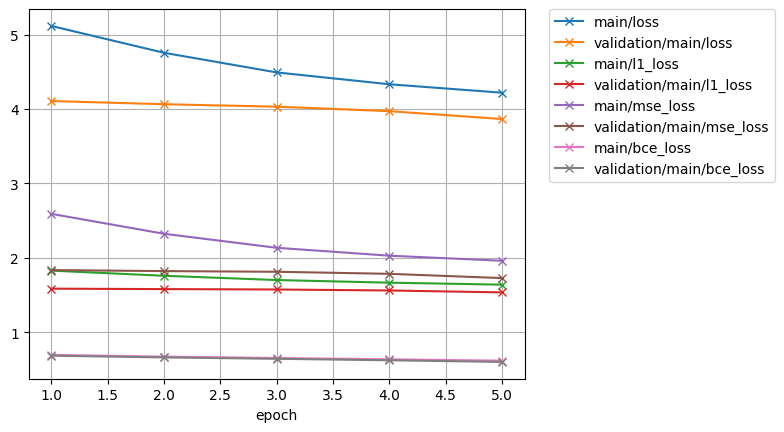

l1 loss curve


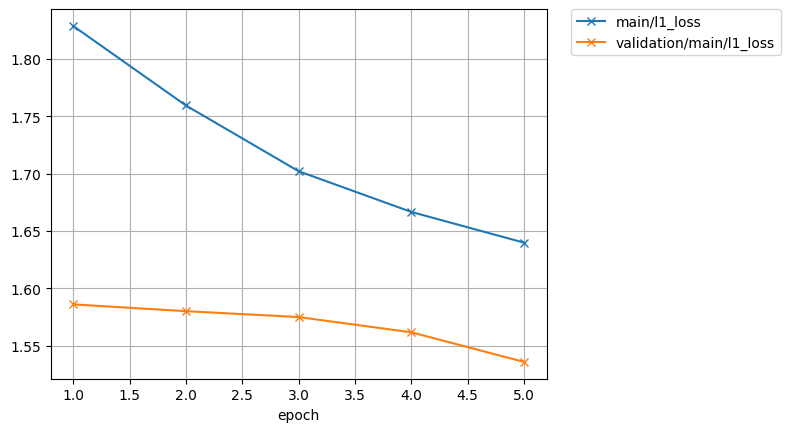

mse loss curve


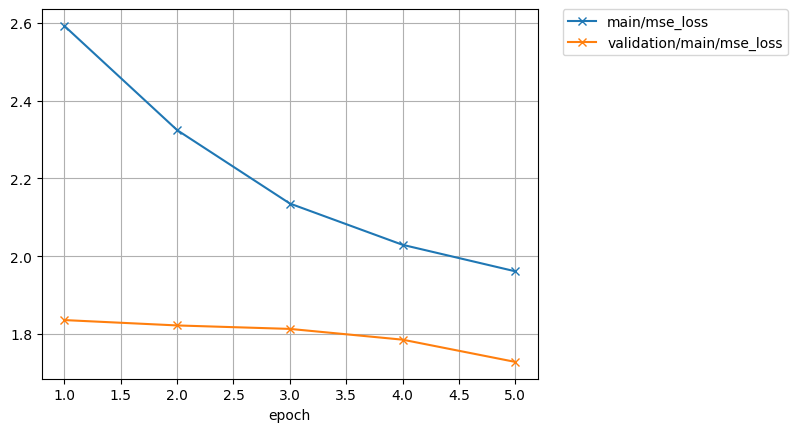

bce loss curve


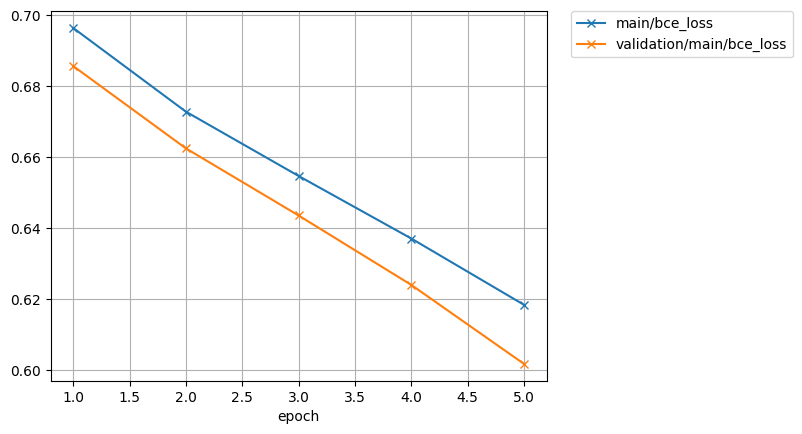

In [30]:
from IPython.display import Image, display_png
print("all loss curve")
display_png(Image("exp/train_nodev_pytorch_train_pytorch_tacotron2_mini/results/all_loss.png", width=500))
print("l1 loss curve")
display_png(Image("exp/train_nodev_pytorch_train_pytorch_tacotron2_mini/results/l1_loss.png", width=500))
print("mse loss curve")
display_png(Image("exp/train_nodev_pytorch_train_pytorch_tacotron2_mini/results/mse_loss.png", width=500))
print("bce loss curve")
display_png(Image("exp/train_nodev_pytorch_train_pytorch_tacotron2_mini/results/bce_loss.png", width=500))

Also, the training curve figures are saved in results directory.  
Let me check the figures.  
These figures are continuously updated during training, so you can monitor with these figures.

`exp/train_*/results/att_ws/*.png` are the figures of attention weights in each epoch.  
In the case of E2E-TTS, it is very important to check that they are diagonal.

Attention weights of initial epoch


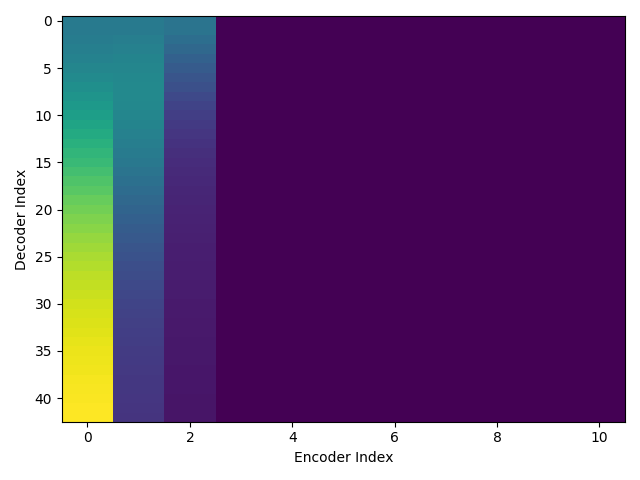

In [31]:
print("Attention weights of initial epoch")
display_png(Image("exp/train_nodev_pytorch_train_pytorch_tacotron2_mini/results/att_ws/fash-cen1-b.ep.1.png", width=500))

Also, the figures of attention weights for validation data are saved every epochs in results/att_ws directory.  
Let me check the figure.  
In the case of TTS, monitoring attention weight is very important to check the training going well.

Also, we support tensorboard.  
You can see the training log through tensorboard.

In [33]:
# only available in colab
%load_ext tensorboard
%tensorboard --logdir tensorboard/train_nodev_pytorch_train_pytorch_tacotron2_mini/

Also we support tensorboard.  
You can see training curve or attention weights explained on the above through tensorboard.

### Stage 4: Network decoding

This stage performs decoding with trained model.

<div align=center>
    <img src=figs/tts_stage4.png width=80%>
</div>

Then, next, Stage 4 E2E-TTS decoding.  
This stage performs decoding using trained E2E-TTS model.

Decoding parameters can be specified by `--decode_config`.

In [34]:
!head -n 32 run.sh | tail -n 1

decode_config=conf/decode.yaml


Decoding configuration in written in `.yaml` format file.  
Let us check the default configuration `conf/decode.yaml`.

In [35]:
!cat conf/decode.yaml

# decoding setting
threshold: 0.5    # threshold to stop the generation
maxlenratio: 10.0 # maximum length of generated samples = input length * maxlenratio
minlenratio: 0.0  # minimum length of generated samples = input length * minlenratio


Decoding parameters can be specified by `--decod_config`.  
Let me check the default decoding yaml file `conf/decode.yaml`.  
threshold is the threshold to stop the feature genearation and the others are for avoiding endless generation.  
Contrast to ASR, TTS decoding parameters are not needed to tune carefully.

In [36]:
# run stage 4 and then stop
!./run.sh --stage 4 --stop_stage 4 --nj 8 --verbose 1 --train_config conf/train_pytorch_tacotron2_mini.yaml 

dictionary: data/lang_1char/train_nodev_units.txt
stage 4: Decoding
2019-09-12 17:05:35,990 (splitjson:40) INFO: /work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/tools/venv/bin/python3 /work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/an4/tts1/../../../utils/splitjson.py --parts 8 exp/train_nodev_pytorch_train_pytorch_tacotron2_mini/outputs_model.loss.best_decode/train_dev/data.json
2019-09-12 17:05:35,992 (splitjson:52) INFO: number of utterances = 100
2019-09-12 17:05:35,998 (splitjson:40) INFO: /work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/tools/venv/bin/python3 /work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/an4/tts1/../../../utils/splitjson.py --parts 8 exp/train_nodev_pytorch_train_pytorch_tacotron2_mini/outputs_model.loss.best_decode/test/data.json
2019-09-12 17:05:36,000 (splitjson:52) INFO: number of utterances = 130
2019-09-12 17:05:36,166 (tt

2019-09-12 17:05:38,969 (tts:570) INFO: inference speed = 2.846193313598633e-07 msec / frame.
2019-09-12 17:05:38,969 (tts:574) INFO: (1/16) mjgm-cen3-b (size:12->50)
2019-09-12 17:05:38,970 (tts:570) INFO: inference speed = 3.3588409423828126e-07 msec / frame.
2019-09-12 17:05:38,970 (tts:574) INFO: (1/12) fjam-an79-b (size:31->50)
2019-09-12 17:05:38,971 (tts:570) INFO: inference speed = 2.741556901198167e-07 msec / frame.
2019-09-12 17:05:38,971 (tts:574) INFO: (1/16) fvap-cen4-b (size:14->65)
2019-09-12 17:05:38,971 (tts:570) INFO: inference speed = 2.924312244762074e-07 msec / frame.
2019-09-12 17:05:38,971 (tts:574) INFO: (1/16) mjwl-cen6-b (size:23->55)
2019-09-12 17:05:38,973 (tts:570) INFO: inference speed = 2.6583353678385414e-07 msec / frame.
2019-09-12 17:05:38,973 (tts:574) INFO: (1/13) fejs-an40-b (size:22->75)
2019-09-12 17:05:38,974 (tts:570) INFO: inference speed = 2.9735883076985676e-07 msec / frame.
2019-09-12 17:05:38,974 (tts:574) INFO: (1/12) ffmm-an295-b (size:28

2019-09-12 17:05:39,948 (tts:570) INFO: inference speed = 1.867407246639854e-07 msec / frame.
2019-09-12 17:05:39,948 (tts:574) INFO: (3/12) fjmd-an8-b (size:20->190)
2019-09-12 17:05:40,247 (tts:570) INFO: inference speed = 2.411222457885742e-07 msec / frame.
2019-09-12 17:05:40,247 (tts:574) INFO: (4/12) fjam-cen2-b (size:10->50)
2019-09-12 17:05:40,250 (tts:570) INFO: inference speed = 2.2993821364182692e-07 msec / frame.
2019-09-12 17:05:40,251 (tts:574) INFO: (4/12) fjdn-cen1-b (size:12->65)
2019-09-12 17:05:40,259 (tts:570) INFO: inference speed = 2.5302886962890625e-07 msec / frame.
2019-09-12 17:05:40,260 (tts:574) INFO: (4/16) miry-cen3-b (size:20->50)
2019-09-12 17:05:40,273 (tts:570) INFO: inference speed = 2.7082516596867485e-07 msec / frame.
2019-09-12 17:05:40,273 (tts:574) INFO: (4/16) fvap-cen7-b (size:38->65)
2019-09-12 17:05:40,276 (tts:570) INFO: inference speed = 2.5059960105202414e-07 msec / frame.
2019-09-12 17:05:40,276 (tts:574) INFO: (4/12) ffmm-cen3-b (size:21

2019-09-12 17:05:41,034 (tts:570) INFO: inference speed = 1.8782913684844971e-07 msec / frame.
2019-09-12 17:05:41,034 (tts:572) WARNING: output length reaches maximum length (fjmd-cen2-b).
2019-09-12 17:05:41,034 (tts:574) INFO: (6/12) fjmd-cen2-b (size:16->160)
2019-09-12 17:05:41,056 (tts:570) INFO: inference speed = 2.140045166015625e-07 msec / frame.
2019-09-12 17:05:41,056 (tts:574) INFO: (6/16) mmxg-an443-b (size:3->25)
2019-09-12 17:05:41,215 (tts:570) INFO: inference speed = 2.890507380167643e-07 msec / frame.
2019-09-12 17:05:41,215 (tts:574) INFO: (7/13) fash-cen4-b (size:16->30)
2019-09-12 17:05:41,243 (tts:570) INFO: inference speed = 2.6330947875976564e-07 msec / frame.
2019-09-12 17:05:41,244 (tts:574) INFO: (7/16) menk-cen3-b (size:23->45)
2019-09-12 17:05:41,244 (tts:570) INFO: inference speed = 2.4190743764241535e-07 msec / frame.
2019-09-12 17:05:41,244 (tts:574) INFO: (7/16) miry-cen6-b (size:23->60)
2019-09-12 17:05:41,248 (tts:570) INFO: inference speed = 2.209633

2019-09-12 17:05:41,992 (tts:570) INFO: inference speed = 2.6749504937065973e-07 msec / frame.
2019-09-12 17:05:41,992 (tts:574) INFO: (9/13) fbbh-cen8-b (size:34->90)
2019-09-12 17:05:41,993 (tts:570) INFO: inference speed = 2.2764856165105647e-07 msec / frame.
2019-09-12 17:05:41,993 (tts:574) INFO: (9/16) marh-an434-b (size:34->110)
2019-09-12 17:05:42,043 (tts:570) INFO: inference speed = 1.7718374729156493e-07 msec / frame.
2019-09-12 17:05:42,043 (tts:572) WARNING: output length reaches maximum length (mmxg-cen1-b).
2019-09-12 17:05:42,043 (tts:574) INFO: (9/16) mmxg-cen1-b (size:16->160)
2019-09-12 17:05:42,276 (tts:570) INFO: inference speed = 2.908966758034446e-07 msec / frame.
2019-09-12 17:05:42,276 (tts:574) INFO: (10/12) fjdn-cen7-b (size:44->55)
2019-09-12 17:05:42,294 (tts:570) INFO: inference speed = 2.0524064699808755e-07 msec / frame.
2019-09-12 17:05:42,294 (tts:574) INFO: (10/16) menk-cen6-b (size:23->120)
2019-09-12 17:05:42,305 (tts:570) INFO: inference speed = 1.

2019-09-12 17:05:43,029 (tts:570) INFO: inference speed = 2.0314852396647135e-07 msec / frame.
2019-09-12 17:05:43,029 (tts:574) INFO: (12/13) ffmm-an293-b (size:28->150)
2019-09-12 17:05:43,036 (tts:570) INFO: inference speed = 1.583986282348633e-05 msec / frame.
2019-09-12 17:05:43,036 (tts:574) INFO: (12/13) fejs-an38-b (size:3->5)
2019-09-12 17:05:43,043 (tts:570) INFO: inference speed = 1.616470515727997e-07 msec / frame.
2019-09-12 17:05:43,043 (tts:572) WARNING: output length reaches maximum length (mmxg-cen4-b).
2019-09-12 17:05:43,043 (tts:574) INFO: (12/16) mmxg-cen4-b (size:32->320)
2019-09-12 17:05:43,060 (tts:570) INFO: inference speed = 1.8869913541353665e-07 msec / frame.
2019-09-12 17:05:43,060 (tts:572) WARNING: output length reaches maximum length (fjam-an78-b).
2019-09-12 17:05:43,060 (tts:574) INFO: (12/12) fjam-an78-b (size:13->130)
2019-09-12 17:05:43,072 (tts:570) INFO: inference speed = 2.2248354825106535e-07 msec / frame.
2019-09-12 17:05:43,072 (tts:574) INFO:

2019-09-12 17:05:44,384 (tts:570) INFO: inference speed = 1.8815994262695313e-07 msec / frame.
2019-09-12 17:05:44,384 (tts:574) INFO: (16/16) mjgm-cen2-b (size:8->65)
2019-09-12 17:05:44,385 (tts:570) INFO: inference speed = 1.8657155939050622e-07 msec / frame.
2019-09-12 17:05:44,386 (tts:572) WARNING: output length reaches maximum length (mmxg-cen8-b).
2019-09-12 17:05:44,386 (tts:574) INFO: (16/16) mmxg-cen8-b (size:37->370)
2019-09-12 17:05:44,549 (tts:570) INFO: inference speed = 2.571378435407366e-07 msec / frame.
2019-09-12 17:05:44,549 (tts:574) INFO: (17/17) fvap-cen3-b (size:19->35)
2019-09-12 17:05:44,557 (tts:570) INFO: inference speed = 2.1556854248046874e-07 msec / frame.
2019-09-12 17:05:44,558 (tts:574) INFO: (17/17) fjlp-an419-b (size:13->50)


Please run the stage 4. It takes several seconds.

Generated features are saved as `ark/scp` format.  
Also figures of attention weights and stop probabilities are saved as `{att_ws/probs}/*.png`.

In [37]:
!tree exp/train_nodev_pytorch_train_pytorch_tacotron2_mini/outputs_model.loss.best_decode

exp/train_nodev_pytorch_train_pytorch_tacotron2_mini/outputs_model.loss.best_decode
├── test
│   ├── att_ws
│   │   ├── fcaw-an406-b_att_ws.png
│   │   ├── fcaw-an407-b_att_ws.png
│   │   ├── fcaw-an408-b_att_ws.png
│   │   ├── fcaw-an409-b_att_ws.png
│   │   ├── fcaw-an410-b_att_ws.png
│   │   ├── fcaw-cen1-b_att_ws.png
│   │   ├── fcaw-cen2-b_att_ws.png
│   │   ├── fcaw-cen3-b_att_ws.png
│   │   ├── fcaw-cen4-b_att_ws.png
│   │   ├── fcaw-cen5-b_att_ws.png
│   │   ├── fcaw-cen6-b_att_ws.png
│   │   ├── fcaw-cen7-b_att_ws.png
│   │   ├── fcaw-cen8-b_att_ws.png
│   │   ├── fjlp-an416-b_att_ws.png
│   │   ├── fjlp-an417-b_att_ws.png
│   │   ├── fjlp-an418-b_att_ws.png
│   │   ├── fjlp-an419-b_att_ws.png
│   │   ├── fjlp-an420-b_att_ws.png
│   │   ├── fjlp-cen1-b_att_ws.png
│   │   ├── fjlp-cen2-b_att_ws.png
│   │   ├── fjlp-cen3-b_att_ws.png
│   │   ├── fjlp-cen4-b_att_ws.png
│   │   ├── fjlp-cen5-b_att_ws.png
│   │   ├── fjlp-cen6-b_att_ws.png
│   │   ├── fjlp-cen7-b_att_ws.png
│   │  

Generated features are saved as ark/scp format.  
Also attention weights and stop probabilities saved as figures.  
Let me check the files.  
By checking the attention weights, we can check the generation is succeeded, or repeating, or deletion.  
Again, in the TTS, checking attention weights is very important.

### Stage 5: Waveform synthesis

This stage synthesizes waveform with Griffin-Lim.

<div align=center>
    <img src=figs/tts_stage5.png width=80%>
</div>

This is the final stage, waveform synthesis.  
This stage performed denormalization of generated features and then synthesizes waveform with Griffin-Lim.

In [38]:
# run stage 5 and then stop
!./run.sh --stage 5 --stop_stage 5 --nj 8 \
    --griffin_lim_iters 8 \
    --train_config conf/train_pytorch_tacotron2_mini.yaml

dictionary: data/lang_1char/train_nodev_units.txt
stage 5: Synthesis
apply-cmvn --norm-vars=true --reverse=true data/train_nodev/cmvn.ark scp:exp/train_nodev_pytorch_train_pytorch_tacotron2_mini/outputs_model.loss.best_decode/test/feats.scp ark,scp:exp/train_nodev_pytorch_train_pytorch_tacotron2_mini/outputs_model.loss.best_decode_denorm/test/feats.ark,exp/train_nodev_pytorch_train_pytorch_tacotron2_mini/outputs_model.loss.best_decode_denorm/test/feats.scp 
apply-cmvn --norm-vars=true --reverse=true data/train_nodev/cmvn.ark scp:exp/train_nodev_pytorch_train_pytorch_tacotron2_mini/outputs_model.loss.best_decode/train_dev/feats.scp ark,scp:exp/train_nodev_pytorch_train_pytorch_tacotron2_mini/outputs_model.loss.best_decode_denorm/train_dev/feats.ark,exp/train_nodev_pytorch_train_pytorch_tacotron2_mini/outputs_model.loss.best_decode_denorm/train_dev/feats.scp 
LOG (apply-cmvn[5.5.480~1-09abd]:main():apply-cmvn.cc:159) Applied cepstral mean and variance normalization to 100 utterances, err

2019-09-12 17:05:47,839 (convert_fbank_to_wav:158) INFO: (1) fbbh-an90-b
2019-09-12 17:05:47,840 (convert_fbank_to_wav:158) INFO: (1) fjmd-an6-b
2019-09-12 17:05:47,841 (convert_fbank_to_wav:158) INFO: (1) fash-an251-b
2019-09-12 17:05:47,844 (convert_fbank_to_wav:158) INFO: (1) fjam-an79-b
2019-09-12 17:05:47,845 (convert_fbank_to_wav:158) INFO: (1) mjgm-cen3-b
2019-09-12 17:05:47,847 (convert_fbank_to_wav:158) INFO: (1) mjwl-cen6-b
2019-09-12 17:05:47,853 (convert_fbank_to_wav:158) INFO: (1) fvap-cen4-b
2019-09-12 17:05:47,854 (convert_fbank_to_wav:158) INFO: (2) fash-an253-b
2019-09-12 17:05:47,855 (convert_fbank_to_wav:158) INFO: (1) ffmm-an295-b
2019-09-12 17:05:47,855 (convert_fbank_to_wav:158) INFO: (1) marh-cen7-b
2019-09-12 17:05:47,859 (convert_fbank_to_wav:158) INFO: (1) fejs-an40-b
2019-09-12 17:05:47,863 (convert_fbank_to_wav:158) INFO: (1) fclc-an150-b
2019-09-12 17:05:47,864 (convert_fbank_to_wav:158) INFO: (1) fjlp-an420-b
2019-09-12 17:05:47,864 (convert_fbank_to_wav:1

2019-09-12 17:05:48,239 (convert_fbank_to_wav:158) INFO: (8) mjwl-an392-b
2019-09-12 17:05:48,250 (convert_fbank_to_wav:158) INFO: (7) fejs-cen6-b
2019-09-12 17:05:48,255 (convert_fbank_to_wav:158) INFO: (11) fcaw-cen6-b
2019-09-12 17:05:48,256 (convert_fbank_to_wav:158) INFO: (8) fclc-cen7-b
2019-09-12 17:05:48,256 (convert_fbank_to_wav:158) INFO: (8) mdms2-cen1-b
2019-09-12 17:05:48,266 (convert_fbank_to_wav:158) INFO: (9) fjmd-cen5-b
2019-09-12 17:05:48,267 (convert_fbank_to_wav:158) INFO: (9) mjwl-an393-b
2019-09-12 17:05:48,268 (convert_fbank_to_wav:158) INFO: (10) fjdn-cen7-b
2019-09-12 17:05:48,283 (convert_fbank_to_wav:158) INFO: (8) fejs-cen7-b
2019-09-12 17:05:48,284 (convert_fbank_to_wav:158) INFO: (7) marh-an432-b
2019-09-12 17:05:48,287 (convert_fbank_to_wav:158) INFO: (10) menk-cen6-b
2019-09-12 17:05:48,295 (convert_fbank_to_wav:158) INFO: (9) mmxg-cen1-b
2019-09-12 17:05:48,300 (convert_fbank_to_wav:158) INFO: (9) mdms2-cen2-b
2019-09-12 17:05:48,304 (convert_fbank_to_w

Please run stage 5.

Generated wav files are saved in 
- `exp/train_nodev_pytorch_*/outputs_model.loss.best_decode_denorm/{train_dev,test}/wav/`

In [39]:
!tree -L 4 exp/train_nodev_pytorch_train_pytorch_tacotron2_mini/*_denorm

exp/train_nodev_pytorch_train_pytorch_tacotron2_mini/outputs_model.loss.best_decode_denorm
├── test
│   ├── feats.ark
│   ├── feats.scp
│   ├── log
│   │   ├── griffin_lim_test.1.log
│   │   ├── griffin_lim_test.2.log
│   │   ├── griffin_lim_test.3.log
│   │   ├── griffin_lim_test.4.log
│   │   ├── griffin_lim_test.5.log
│   │   ├── griffin_lim_test.6.log
│   │   ├── griffin_lim_test.7.log
│   │   └── griffin_lim_test.8.log
│   └── wav
│       ├── fcaw-an406-b.wav
│       ├── fcaw-an407-b.wav
│       ├── fcaw-an408-b.wav
│       ├── fcaw-an409-b.wav
│       ├── fcaw-an410-b.wav
│       ├── fcaw-cen1-b.wav
│       ├── fcaw-cen2-b.wav
│       ├── fcaw-cen3-b.wav
│       ├── fcaw-cen4-b.wav
│       ├── fcaw-cen5-b.wav
│       ├── fcaw-cen6-b.wav
│       ├── fcaw-cen7-b.wav
│       ├── fcaw-cen8-b.wav
│       ├── fjlp-an416-b.wav
│       ├── fjlp-an417-b.wav
│       ├── fjlp-an418-b.wav
│       ├── fjlp-an419-b.wav
│       ├── fjlp-an420-b.wav
│       ├── fjlp-cen1-b.wav
│       ├── fjlp-c

Generated waveforms are saved in here.  
Let me check the files.  
You can see generated wavefiles.  
Now you finished building your own E2E-TTS model!  
Unfortunately, this model cannnot generate a good speech.  
So let us listen to the samples in demo HP.

Now you finish building your own E2E-TTS model!

But unfortunately, this model cannot generate a good speech.  
Let us listen to the samples in demo HP to check the quality.  
https://espnet.github.io/espnet-tts-sample/

### TIPS: How to conduct your experiments

Once we finish stage 2, we can start to try several settings in parallel.  
Here I will show the basic flow of experiments.

In [40]:
%%bash
# move on recipe directory and then run the recipe until stage 2 
cd ../../mini_an4/tts1
./run.sh --stop_stage 2

stage -1: Data Download
stage 0: Data preparation
stage 1: Feature Generation
/work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/mini_an4/tts1/../../../utils/make_fbank.sh --cmd stdout.pl --nj 2 --fs 16000 --fmax  --fmin  --n_fft 1024 --n_shift 256 --win_length  --n_mels 80 data/train exp/make_fbank/train fbank
/work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/mini_an4/tts1/../../../utils/make_fbank.sh: moving data/train/feats.scp to data/train/.backup
utils/validate_data_dir.sh: Successfully validated data-directory data/train
/work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/mini_an4/tts1/../../../utils/make_fbank.sh: [info]: no segments file exists: assuming pcm.scp indexed by utterance.
Succeeded creating filterbank features for train
/work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/mini_an4/tts1/../../../utils/make_fbank.sh --cmd stdout.pl --nj 2 

compute-cmvn-stats scp:data/train_nodev/feats.scp data/train_nodev/cmvn.ark 
LOG (compute-cmvn-stats[5.5.480~1-09abd]:main():compute-cmvn-stats.cc:168) Wrote global CMVN stats to data/train_nodev/cmvn.ark
LOG (compute-cmvn-stats[5.5.480~1-09abd]:main():compute-cmvn-stats.cc:171) Done accumulating CMVN stats for 3 utterances; 0 had errors.
/work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/mini_an4/tts1/../../../utils/data2json.sh --feat dump/train_nodev/feats.scp data/train_nodev data/lang_1char/train_nodev_units.txt
/work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/mini_an4/tts1/../../../utils/feat_to_shape.sh --cmd run.pl --nj 1 --filetype  --preprocess-conf  --verbose 0 dump/train_nodev/feats.scp data/train_nodev/tmp-lse21/input/shape.scp
/work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/mini_an4/tts1/../../../utils/data2json.sh --feat dump/train_dev/feats.scp data/train_dev data/lan

You can change hyperparameter via command line with `change_yaml.py`.  

In [41]:
%%bash
# move on recipe directory
cd ../../mini_an4/tts1

# make a path to utilities
. ./path.sh

# run experiment
for bs in 32 64; do
    ./run.sh --stage 3 --train_config $(change_yaml.py -a batch-size=$bs -a epochs=1 conf/train_pytorch_mini_tacotron2.yaml)
    echo "$bs exp finished."
done

dictionary: data/lang_1char/train_nodev_units.txt
stage 3: Text-to-speech model training
2019-09-12 17:06:03,086 (tts_train:168) INFO: ngpu: 0
2019-09-12 17:06:03,086 (tts_train:171) INFO: random seed = 1
2019-09-12 17:06:03,219 (deterministic_utils:24) INFO: torch type check is disabled
2019-09-12 17:06:03,484 (tts:273) INFO: #input dims : 19
2019-09-12 17:06:03,485 (tts:274) INFO: #output dims: 80
2019-09-12 17:06:03,486 (tts:291) INFO: writing a model config file toexp/train_nodev_pytorch_train_pytorch_mini_tacotron2_batch-size32_epochs1/results/model.json
2019-09-12 17:06:03,486 (tts:295) INFO: ARGS: accum_grad: 1
2019-09-12 17:06:03,486 (tts:295) INFO: ARGS: aconv_chans: 4
2019-09-12 17:06:03,486 (tts:295) INFO: ARGS: aconv_filts: 1
2019-09-12 17:06:03,486 (tts:295) INFO: ARGS: adim: 4
2019-09-12 17:06:03,487 (tts:295) INFO: ARGS: atype: location
2019-09-12 17:06:03,487 (tts:295) INFO: ARGS: backend: pytorch
2019-09-12 17:06:03,487 (tts:295) INFO: ARGS: batch_bins: 0
2019-09-12 17

2019-09-12 17:06:05,930 (splitjson:40) INFO: /work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/tools/venv/bin/python3 /work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/mini_an4/tts1/../../../utils/splitjson.py --parts 2 exp/train_nodev_pytorch_train_pytorch_mini_tacotron2_batch-size32_epochs1/outputs_model.loss.best_mini_decode/test/data.json
2019-09-12 17:06:05,931 (splitjson:52) INFO: number of utterances = 2
2019-09-12 17:06:05,943 (splitjson:40) INFO: /work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/tools/venv/bin/python3 /work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/mini_an4/tts1/../../../utils/splitjson.py --parts 2 exp/train_nodev_pytorch_train_pytorch_mini_tacotron2_batch-size32_epochs1/outputs_model.loss.best_mini_decode/train_dev/data.json
2019-09-12 17:06:05,944 (splitjson:52) INFO: number of utterances = 2
apply-cmvn --norm-vars=true --reverse

In [42]:
!tree -L 2 ../../mini_an4/tts1/exp

../../mini_an4/tts1/exp
├── dump_feats
│   ├── dev
│   ├── eval
│   └── train
├── make_fbank
│   ├── test
│   └── train
├── train_nodev_pytorch_train_pytorch_mini_tacotron2
├── train_nodev_pytorch_train_pytorch_mini_tacotron2_batch-size128_epochs1
│   ├── outputs_model.loss.best_mini_decode
│   ├── outputs_model.loss.best_mini_decode_denorm
│   ├── results
│   └── train.log
├── train_nodev_pytorch_train_pytorch_mini_tacotron2_batch-size32_epochs1
│   ├── outputs_model.loss.best_mini_decode
│   ├── outputs_model.loss.best_mini_decode_denorm
│   ├── results
│   └── train.log
└── train_nodev_pytorch_train_pytorch_mini_tacotron2_batch-size64_epochs1
    ├── outputs_model.loss.best_mini_decode
    ├── outputs_model.loss.best_mini_decode_denorm
    ├── results
    └── train.log

20 directories, 3 files


If you have job control system like `slurm` or `torque`, you can accelerate the experiments!  
The processing in each stage will be automatically submitted to job control system.

In [43]:
%%bash
######################################################
###     DOES NOT WORK IN COLAB, JUST AN EXAMPLE    ###
######################################################
# move on recipe directory
cd ../../mini_an4/tts1

# change cmd backend to slurm
sed -ie "s/cmd_backend='stdout'/cmd_backend='slurm'/g" cmd.sh

# make a path to utilities
. ./path.sh

# submit a job
for bs in 32 64 128 256; do
    sbatch -J mini_an4_batchsize_${bs} \
        ./run.sh --stage 3 --train_config $(change_yaml.py -a batch-size=$bs -a epochs=1 conf/train_pytorch_mini_tacotron2.yaml) 
done

Submitted batch job 871756
Submitted batch job 871757
Submitted batch job 871758
Submitted batch job 871759


## 3. Demonstration of the use of pretrained models

We provide pretrained TTS models and these are easy to use with `espnet/utils/synth_wav.sh`.

In [44]:
# move on directory
os.chdir("../../librispeech/asr1")
!pwd

/work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/librispeech/asr1


OK. Let us move on the final topic of my demonstration.  
That is the use of pretrained model.  
ESPnet provides some utilities tools to use pretrained model.  
Here I will introduce the usage of them.  
Please run the cell to move on the directory.

Let us check the usage of `espnet/utils/synth_wav.sh`.  
It will automatically downloads pretrained model from online, you do not need to prepare anything.  

In [45]:
!../../../utils/synth_wav.sh --help

Usage:
    $ ../../../utils/synth_wav.sh <text>

Example:
    # make text file and then generate it
    echo "This is a demonstration of text to speech." > example.txt
    ../../../utils/synth_wav.sh example.txt

    # you can specify the pretrained models
    ../../../utils/synth_wav.sh --models ljspeech.tacotron2.v3 example.txt

    # if you want to try wavenet vocoder, extend stage
    ../../../utils/synth_wav.sh --models ljspeech.tacotron2.v3 --stop_stage 4 example.txt

    # also you can specify vocoder model
    ../../../utils/synth_wav.sh --models ljspeech.tacotron2.v3 --vocoder_models ljspeech.wavenet.softmax.ns.v1 --stop_stage 4 example.txt

Available models:
    - libritts.tacotron2.v1
    - ljspeech.tacotron2.v1
    - ljspeech.tacotron2.v2
    - ljspeech.tacotron2.v3
    - ljspeech.transformer.v1
    - ljspeech.transformer.v2
    - ljspeech.fastspeech.v1
    - ljspeech.fastspeech.v2
    - libritts.transformer.v1

Available vocoder models:
    - ljspeech.wavenet.softmax.ns.v1

To use the TTS pretrained model, we provide `synth_wav.sh`.  
Let me check the usage of it.  
This script will automatically download specified pretrained model and then perform generation. 
So you do not need to prepare anything.

Let us generate your own text with pretrained models!

Please input your favorite sentence!
This is a demonstration of end to end text to speech.
stage 0: Data preparation
/work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/librispeech/asr1/../../../utils/data2json.sh decode/example/data decode/download/ljspeech.transformer.v1/data/lang_1char/train_no_dev_units.txt
stage 2: Decoding
stage 3: Synthesis with Griffin-Lim
apply-cmvn --norm-vars=true --reverse=true decode/download/ljspeech.transformer.v1/data/train_no_dev/cmvn.ark scp:decode/example/outputs/feats.scp ark,scp:decode/example/outputs_denorm/feats.ark,decode/example/outputs_denorm/feats.scp 
LOG (apply-cmvn[5.5.480~1-09abd]:main():apply-cmvn.cc:159) Applied cepstral mean and variance normalization to 1 utterances, errors on 0
/work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/librispeech/asr1/../../../utils/convert_fbank.sh --nj 1 --cmd run.pl --fs 22050 --fmax  --fmin  --n_fft 1024 --n_shift 256 --win_length  --n_mel

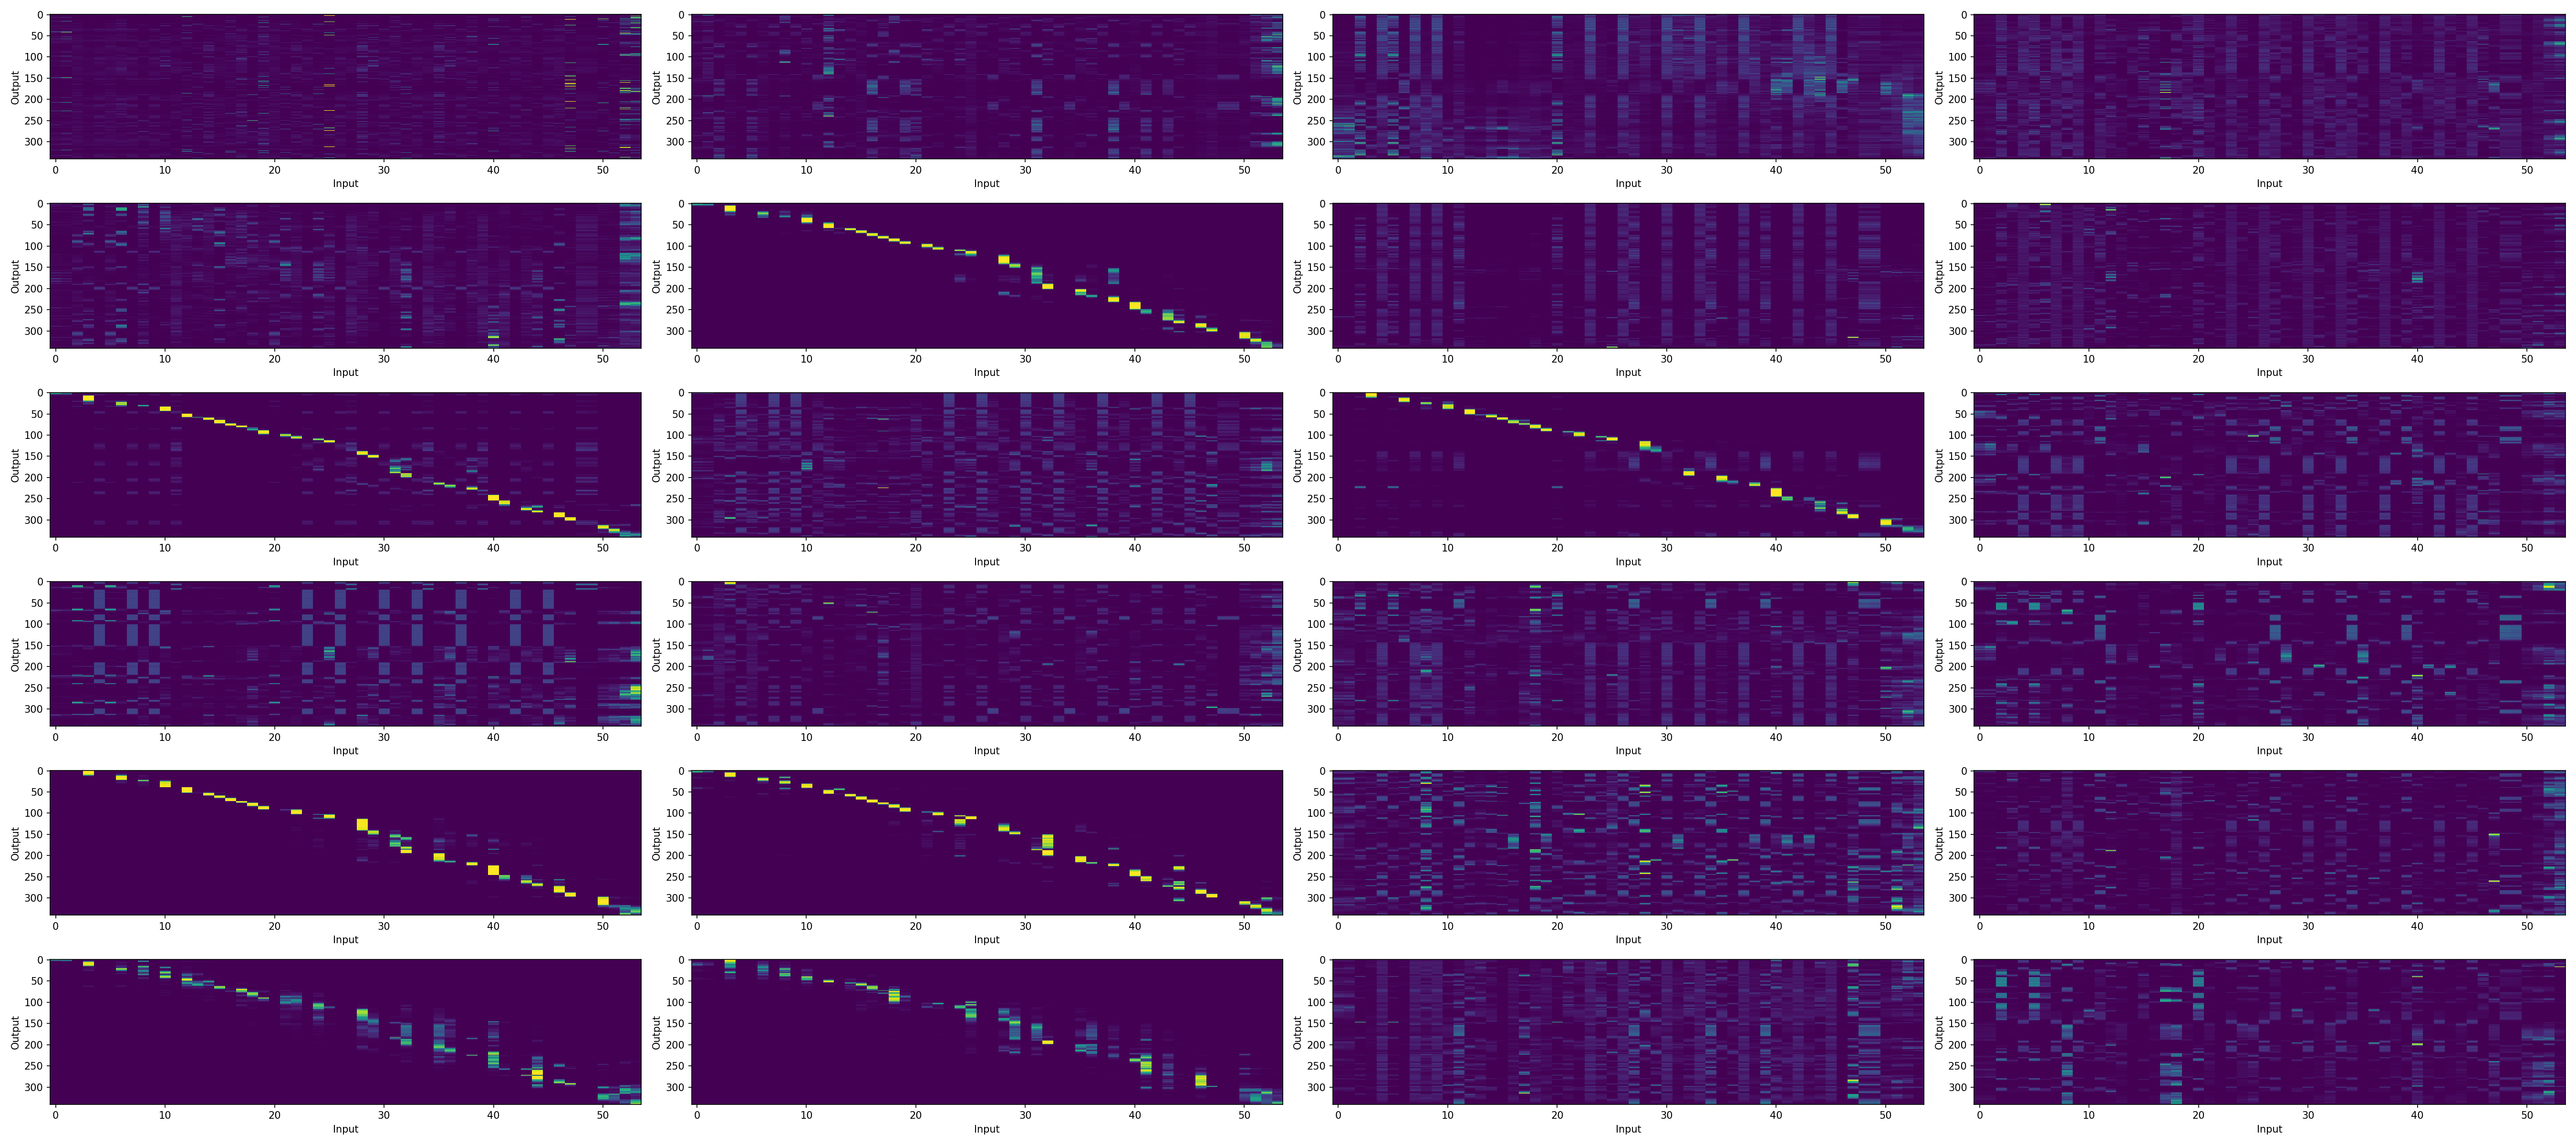

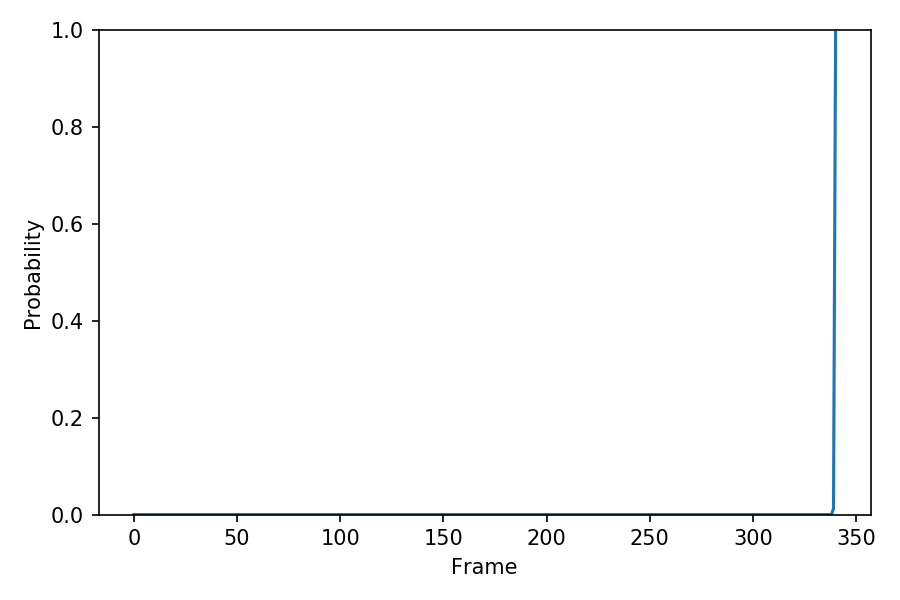

In [46]:
# generate your sentence!
!rm -rf decode/example
print("Please input your favorite sentence!")
text = input()
text = text.upper()
with open("example.txt", "w") as f:
    f.write(text)

# you can change here to select the pretrained model
# !../../../utils/synth_wav.sh --models ljspeech.fastspeech.v1 example.txt
# !../../../utils/synth_wav.sh --models ljspeech.tacotron2.v3 example.txt
!../../../utils/synth_wav.sh --models ljspeech.transformer.v1 example.txt

# check generated audio
import IPython.display
IPython.display.display(IPython.display.Audio("decode/example/wav/example.wav"))

# check attention and probs
if os.path.exists("decode/example/outputs/att_ws/example_att_ws.png"):
    display_png(Image("decode/example/outputs/att_ws/example_att_ws.png", width=1000))
    display_png(Image("decode/example/outputs/probs/example_prob.png", width=500))

Let us generate your sentence. Please run the cell.  
At first we use pretrained fastspeech.  
Let me check the sample.
Next let me use tacotron2.  
You can see the attention weights and stop probabilities.  
The attention weights are diagonal, which is an evidence of successful generation.
Finally, let us use Transformer.
You can see many attention weigths.  
Interestingly, only the some of the heads are diagonal in Transformer.  
And the attention is not continuous.

Also you can try the wavenet vocoder, but it takes time to decode.

In [47]:
# generate your sentence!
!rm -rf decode/example_short
print("Please input your favorite sentence!")
text = input()
text = text.upper()
with open("example_short.txt", "w") as f:
    f.write(text)
    
# extend stop_stage
!../../../utils/synth_wav.sh --stop_stage 4 --models ljspeech.tacotron2.v3 example_short.txt

# check generated audio
IPython.display.display(IPython.display.Audio("decode/example_short/wav/example_short.wav"))
IPython.display.display(IPython.display.Audio("decode/example_short/wav_wnv/example_short_gen.wav"))

Please input your favorite sentence!
Apple
stage 0: Data preparation
/work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/librispeech/asr1/../../../utils/data2json.sh decode/example_short/data decode/download/ljspeech.tacotron2.v3/data/lang_1char/train_no_dev_units.txt
stage 2: Decoding
stage 3: Synthesis with Griffin-Lim
apply-cmvn --norm-vars=true --reverse=true decode/download/ljspeech.tacotron2.v3/data/train_no_dev/cmvn.ark scp:decode/example_short/outputs/feats.scp ark,scp:decode/example_short/outputs_denorm/feats.ark,decode/example_short/outputs_denorm/feats.scp 
LOG (apply-cmvn[5.5.480~1-09abd]:main():apply-cmvn.cc:159) Applied cepstral mean and variance normalization to 1 utterances, errors on 0
/work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/librispeech/asr1/../../../utils/convert_fbank.sh --nj 1 --cmd run.pl --fs 22050 --fmax  --fmin  --n_fft 1024 --n_shift 256 --win_length  --n_mels 80 --iters 64 decode/examp

You also try the wavenet vocoder, but it takes time.  
Let us generate very short sentence.  
You can confirm that the naturalness improved significantly but the pronunciation itself is the same.

ESPnet also provides the `espnet/utils/recog_wav.sh` to use pretrained ASR models.  
Let us recognize the generated speech!

In [48]:
!../../../utils/recog_wav.sh --help

Usage:
    ../../../utils/recog_wav.sh [options] <wav_file>

Options:
    --backend <chainer|pytorch>     # chainer or pytorch (Default: pytorch)
    --ngpu <ngpu>                   # Number of GPUs (Default: 0)
    --decode_dir <directory_name>   # Name of directory to store decoding temporary data
    --models <model_name>           # Model name (e.g. tedlium2.tacotron2.v1)
    --cmvn <path>                   # Location of cmvn.ark
    --lang_model <path>             # Location of language model
    --recog_model <path>            # Location of E2E model
    --decode_config <path>          # Location of configuration file
    --api <api_version>             # API version (v1 or v2, available in only pytorch backend)

Example:
    # Record audio from microphone input as example.wav
    rec -c 1 -r 16000 example.wav trim 0 5

    # Decode using model name
    ../../../utils/recog_wav.sh --models tedlium2.rnn.v1 example.wav

    # Decode using model file
    ../../../utils/recog_wav.sh 

ESPnet also provides the utility `recong_wav.sh` to use pretrained ASR model.  
Let us check the usage.  
This script will also automatically download pretrained ASR model.  
So you do not need to prepare anything.

In [49]:
# downsample to 16 kHz for ASR model
!sox decode/example/wav/example.wav -b 16 decode/example/wav/example_16k.wav rate 16k

# make decode config
import yaml
with open("conf/decode_sample.yaml", "w") as f:
    yaml.dump({
        "batchsize": 0,
        "beam-size": 5,
        "ctc-weight": 0.4,
        "lm-weight": 0.6,
        "maxlenratio": 0.0,
        "minlenratio": 0.0,
        "penalty": 0.0,
    }, f, Dumper=yaml.Dumper)

# let's recognize generated speech
!../../../utils/recog_wav.sh --models librispeech.transformer.v1 \
    --decode_config conf/decode_sample.yaml \
    decode/example/wav/example_16k.wav

stage 0: Data preparation
stage 1: Feature Generation
steps/make_fbank_pitch.sh --cmd run.pl --nj 1 --write_utt2num_frames true decode/example_16k/data decode/example_16k/log decode/example_16k/fbank
steps/make_fbank_pitch.sh: moving decode/example_16k/data/feats.scp to decode/example_16k/data/.backup
utils/validate_data_dir.sh: WARNING: you have only one speaker.  This probably a bad idea.
   Search for the word 'bold' in http://kaldi-asr.org/doc/data_prep.html
   for more information.
utils/validate_data_dir.sh: Successfully validated data-directory decode/example_16k/data
steps/make_fbank_pitch.sh: [info]: no segments file exists: assuming wav.scp indexed by utterance.
steps/make_fbank_pitch.sh: Succeeded creating filterbank and pitch features for data
/work5/t_hayashi/work/is18_tutorial_espnet/notebooks/interspeech2019_tts/espnet/egs/librispeech/asr1/../../../utils/dump.sh --cmd run.pl --nj 1 --do_delta false decode/example_16k/data/feats.scp decode/download/librispeech.transformer

Here, let us recognize the generated speech.  
Librispeech transformer models is big, it takes several seconds.  
Yes, the model successfully recognized the generated speech.

## Conclusion

- Can build TTS model with unified-design recipe
- Can combine ASR model with TTS model easily

Through ESPnet, you can build / use E2E-TTS and E2E-ASR in the same manner!

Thank you for your attention!